# ECTP Slab Analysis

This notebook analyzes all snow pits in the data directory and creates slabs based on ECTP (Extended Column Test with Propagation) failures.

## Workflow
1. Parse all CAAML files in the data directory
2. Create Pit objects from the snowpylot SnowPit data
3. Extract slabs using `weak_layer_def="ECTP_failure_layer"`
4. Analyze and summarize the slab characteristics

In [7]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add src to path if needed
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from snowpyt_mechparams.snowpilot_utils import parse_caaml_file
from snowpyt_mechparams.data_structures import Pit, Slab

## 1. Load and Parse CAAML Files

We'll load all CAAML files from the data directory and create Pit objects.

In [8]:
# Set data directory path
data_dir = Path.cwd() / 'data'
print(f"Data directory: {data_dir}")
print(f"Exists: {data_dir.exists()}")

# Get all CAAML files
caaml_files = list(data_dir.glob('snowpits-*-caaml.xml'))
print(f"\nFound {len(caaml_files):,} CAAML files")

Data directory: /Users/marykate/Desktop/Snow/SnowPyt-MechParams/examples/data
Exists: True

Found 50,278 CAAML files


In [9]:
# Parse CAAML files and create Pits
# Note: This may take several minutes with 50k+ files
print("Parsing CAAML files and creating Pits...")

pits = []
failed_files = []

for filepath in tqdm(caaml_files, desc="Processing files"):
    try:
        # Parse CAAML file to get snowpylot SnowPit
        snow_pit = parse_caaml_file(str(filepath))
        
        # Create Pit object
        pit = Pit.from_snow_pit(snow_pit)
        pits.append(pit)
        
    except Exception as e:
        failed_files.append((filepath.name, str(e)))

print(f"\nSuccessfully parsed: {len(pits):,} pits")
print(f"Failed: {len(failed_files):,} files")

if failed_files:
    print(f"\nFirst 5 failures:")
    for fname, error in failed_files[:5]:
        print(f"  {fname}: {error}")

Parsing CAAML files and creating Pits...


Processing files: 100%|██████████| 50278/50278 [00:14<00:00, 3532.06it/s]


Successfully parsed: 50,278 pits
Failed: 0 files


## 2. Create Slabs from ECTP Failures

For each pit, we'll create slabs based on Extended Column Tests with propagation (ECTP).

In [10]:
# Create slabs using ECTP failure layers
print("Creating slabs from ECTP failures...")

all_slabs = []
pits_with_ectp = 0
total_ectp_tests = 0

for pit in tqdm(pits, desc="Creating slabs"):
    # Create slabs based on ECTP failures
    slabs = pit.create_slabs(weak_layer_def="ECTP_failure_layer")
    
    if slabs:
        pits_with_ectp += 1
        all_slabs.extend(slabs)
        
        # Count total ECTP tests in this pit
        if pit.ECT_results:
            total_ectp_tests += len(slabs)

print(f"\nTotal pits processed: {len(pits):,}")
print(f"Pits with ECTP failures: {pits_with_ectp:,} ({100*pits_with_ectp/len(pits):.1f}%)")
print(f"Total ECTP tests with propagation: {total_ectp_tests:,}")
print(f"Total slabs created: {len(all_slabs):,}")

Creating slabs from ECTP failures...


Creating slabs: 100%|██████████| 50278/50278 [00:00<00:00, 933614.98it/s]


Total pits processed: 50,278
Pits with ECTP failures: 12,347 (24.6%)
Total ECTP tests with propagation: 14,776
Total slabs created: 14,776


## 3. Summary Statistics

Let's analyze the characteristics of the slabs created from ECTP failures.

In [11]:
# Extract slab characteristics
slab_data = []

for slab in all_slabs:
    # Calculate slab metrics
    num_layers = len(slab.layers)
    total_thickness = slab.total_thickness
    slope_angle = slab.angle
    
    # Weak layer properties
    weak_layer_depth = slab.weak_layer.depth_top if slab.weak_layer else None
    weak_layer_thickness = slab.weak_layer.thickness if slab.weak_layer else None
    weak_layer_hardness = slab.weak_layer.hand_hardness if slab.weak_layer else None
    weak_layer_grain_form = slab.weak_layer.grain_form if slab.weak_layer else None
    
    # Test metadata
    test_score = slab.test_result_properties.get('score') if slab.test_result_properties else None
    
    slab_data.append({
        'pit_id': slab.pit_id,
        'slab_id': slab.slab_id,
        'num_layers': num_layers,
        'total_thickness_cm': total_thickness,
        'slope_angle_deg': slope_angle,
        'weak_layer_depth_cm': weak_layer_depth,
        'weak_layer_thickness_cm': weak_layer_thickness,
        'weak_layer_hardness': weak_layer_hardness,
        'weak_layer_grain_form': weak_layer_grain_form,
        'test_score': test_score,
        'test_index': slab.test_result_index,
        'n_tests_in_pit': slab.n_test_results_in_pit,
    })

# Create DataFrame
df = pd.DataFrame(slab_data)

# Convert columns that may contain UFloat/uncertainty values to plain float
# (describe() needs numeric columns to return mean, std, etc.)
def safe_float(val):
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return np.nan
    if hasattr(val, 'nominal_value'):
        return float(val.nominal_value)
    try:
        return float(val)
    except (TypeError, ValueError):
        return np.nan

for col in ['slope_angle_deg', 'weak_layer_depth_cm', 'weak_layer_thickness_cm']:
    if col in df.columns:
        df[col] = df[col].apply(safe_float)

print(f"Created DataFrame with {len(df):,} rows")
df.head(10)

Created DataFrame with 14,776 rows


,pit_id,slab_id,num_layers,total_thickness_cm,slope_angle_deg,weak_layer_depth_cm,weak_layer_thickness_cm,weak_layer_hardness,weak_layer_grain_form,test_score,test_index,n_tests_in_pit
0,51686,51686_slab_0,5,105.0,38.0,105.0,5.0,F+,FCxr,ECTP24,0,1
1,18792,18792_slab_0,4,47.0,30.0,47.0,29.0,4F-,NaN,ECTP18,0,1
2,51365,51365_slab_0,4,60.0,35.0,60.0,1.0,P,MFcr,ECTP27,0,1
3,58244,58244_slab_0,1,41.0,25.0,41.0,1.0,F-,SHsu,ECTP4,0,2
4,58244,58244_slab_1,6,93.0,25.0,93.0,19.0,4F,FC,ECTP14,1,2
5,11350,11350_slab_0,2,55.0,20.0,55.0,9.0,4F+,NaN,ECTP14,0,2
6,11350,11350_slab_1,4,87.0,20.0,87.0,40.0,NaN,NaN,ECTP16,1,2
7,7590,7590_slab_0,1,17.0,NaN,17.0,5.0,F,DF,ECTP12,0,1
8,44399,44399_slab_0,1,44.0,28.0,44.0,11.0,F,FCso,ECTP10,0,1
9,27704,27704_slab_0,5,35.0,18.0,35.0,35.0,F+,DH,ECTP22,0,1


### Basic Statistics

In [12]:
print("=" * 60)
print("SLAB SUMMARY STATISTICS")
print("=" * 60)

print("\n1. OVERALL COUNTS")
print(f"   Total slabs: {len(df):,}")
print(f"   Unique pits: {df['pit_id'].nunique():,}")
print(f"   Avg slabs per pit: {len(df) / df['pit_id'].nunique():.2f}")

print("\n2. SLAB THICKNESS (cm)")
thickness_stats = df['total_thickness_cm'].describe()
print(f"   Mean: {thickness_stats['mean']:.1f} cm")
print(f"   Median: {thickness_stats['50%']:.1f} cm")
print(f"   Std Dev: {thickness_stats['std']:.1f} cm")
print(f"   Range: {thickness_stats['min']:.1f} - {thickness_stats['max']:.1f} cm")

print("\n3. NUMBER OF LAYERS IN SLAB")
layers_stats = df['num_layers'].describe()
print(f"   Mean: {layers_stats['mean']:.1f}")
print(f"   Median: {layers_stats['50%']:.0f}")
print(f"   Range: {int(layers_stats['min'])} - {int(layers_stats['max'])}")

print("\n4. SLOPE ANGLE (degrees)")
slope_stats = df['slope_angle_deg'].describe()
print(f"   Mean: {slope_stats['mean']:.1f}°")
print(f"   Median: {slope_stats['50%']:.1f}°")
print(f"   Range: {slope_stats['min']:.1f}° - {slope_stats['max']:.1f}°")

print("\n5. WEAK LAYER DEPTH (cm from surface)")
depth_stats = df['weak_layer_depth_cm'].describe()
print(f"   Mean: {depth_stats['mean']:.1f} cm")
print(f"   Median: {depth_stats['50%']:.1f} cm")
print(f"   Range: {depth_stats['min']:.1f} - {depth_stats['max']:.1f} cm")

print("\n6. WEAK LAYER GRAIN FORMS")
grain_counts = df['weak_layer_grain_form'].value_counts().head(10)
print(f"   Total unique grain forms: {df['weak_layer_grain_form'].nunique()}")
print(f"\n   Top 10 most common:")
for grain, count in grain_counts.items():
    pct = 100 * count / len(df)
    print(f"      {grain}: {count:,} ({pct:.1f}%)")

print("\n7. WEAK LAYER HARDNESS")
hardness_counts = df['weak_layer_hardness'].value_counts()
print(f"   Total unique hardness values: {df['weak_layer_hardness'].nunique()}")
for hardness, count in hardness_counts.items():
    pct = 100 * count / len(df)
    print(f"      {hardness}: {count:,} ({pct:.1f}%)")

print("\n" + "=" * 60)

SLAB SUMMARY STATISTICS

1. OVERALL COUNTS
   Total slabs: 14,776
   Unique pits: 12,347
   Avg slabs per pit: 1.20

2. SLAB THICKNESS (cm)
   Mean: 48.6 cm
   Median: 45.0 cm
   Std Dev: 25.4 cm
   Range: 0.1 - 253.0 cm

3. NUMBER OF LAYERS IN SLAB
   Mean: 3.9
   Median: 4
   Range: 1 - 18

4. SLOPE ANGLE (degrees)
   Mean: 26.5°
   Median: 27.0°
   Range: 0.0° - 90.0°

5. WEAK LAYER DEPTH (cm from surface)
   Mean: 48.7 cm
   Median: 45.0 cm
   Range: 0.1 - 253.0 cm

6. WEAK LAYER GRAIN FORMS
   Total unique grain forms: 41

   Top 10 most common:
      FC: 3,749 (25.4%)
      FCso: 1,349 (9.1%)
      FCxr: 1,291 (8.7%)
      DH: 1,151 (7.8%)
      MFcr: 913 (6.2%)
      DF: 691 (4.7%)
      SH: 662 (4.5%)
      RG: 468 (3.2%)
      FCsf: 443 (3.0%)
      RGxf: 190 (1.3%)

7. WEAK LAYER HARDNESS
   Total unique hardness values: 18
      F: 4,553 (30.8%)
      4F: 3,029 (20.5%)
      1F: 1,252 (8.5%)
      4F-: 828 (5.6%)
      P: 799 (5.4%)
      F+: 638 (4.3%)
      F-: 570 (3.9%)


## 4. Visualizations

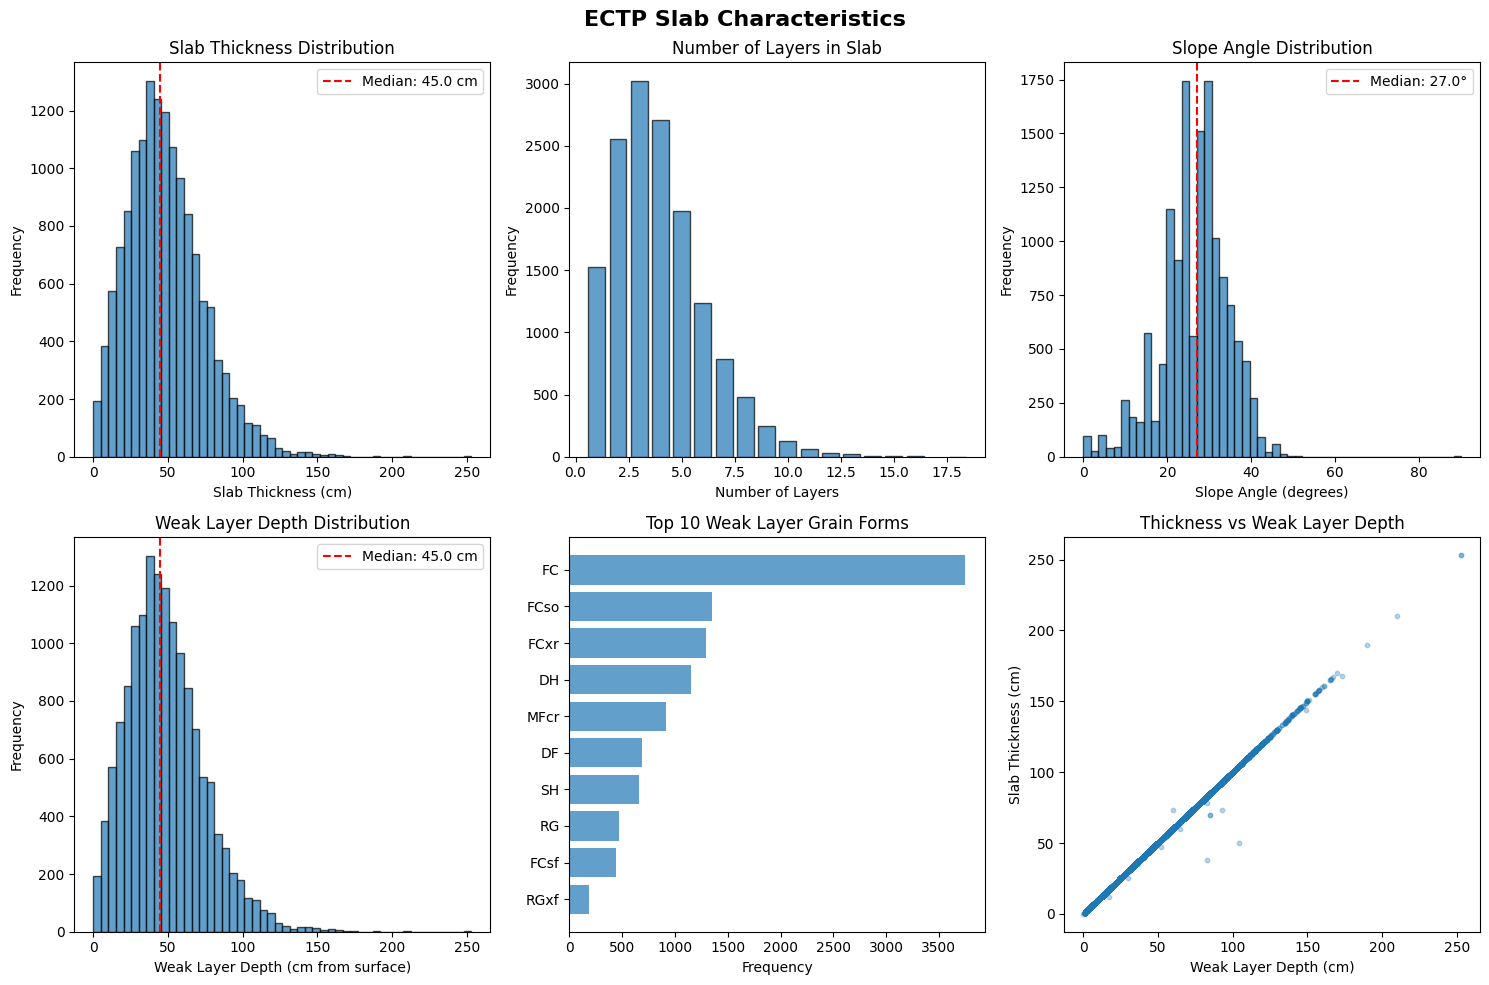

In [13]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('ECTP Slab Characteristics', fontsize=16, fontweight='bold')

# 1. Slab thickness distribution
axes[0, 0].hist(df['total_thickness_cm'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Slab Thickness (cm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Slab Thickness Distribution')
axes[0, 0].axvline(df['total_thickness_cm'].median(), color='red', linestyle='--', 
                   label=f'Median: {df["total_thickness_cm"].median():.1f} cm')
axes[0, 0].legend()

# 2. Number of layers in slab
layer_counts = df['num_layers'].value_counts().sort_index()
axes[0, 1].bar(layer_counts.index, layer_counts.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Layers')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Number of Layers in Slab')

# 3. Slope angle distribution
axes[0, 2].hist(df['slope_angle_deg'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Slope Angle (degrees)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Slope Angle Distribution')
axes[0, 2].axvline(df['slope_angle_deg'].median(), color='red', linestyle='--',
                   label=f'Median: {df["slope_angle_deg"].median():.1f}°')
axes[0, 2].legend()

# 4. Weak layer depth distribution
axes[1, 0].hist(df['weak_layer_depth_cm'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Weak Layer Depth (cm from surface)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Weak Layer Depth Distribution')
axes[1, 0].axvline(df['weak_layer_depth_cm'].median(), color='red', linestyle='--',
                   label=f'Median: {df["weak_layer_depth_cm"].median():.1f} cm')
axes[1, 0].legend()

# 5. Top 10 weak layer grain forms
top_grains = df['weak_layer_grain_form'].value_counts().head(10)
axes[1, 1].barh(range(len(top_grains)), top_grains.values, alpha=0.7)
axes[1, 1].set_yticks(range(len(top_grains)))
axes[1, 1].set_yticklabels(top_grains.index)
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Top 10 Weak Layer Grain Forms')
axes[1, 1].invert_yaxis()

# 6. Scatter: Thickness vs Weak Layer Depth
axes[1, 2].scatter(df['weak_layer_depth_cm'], df['total_thickness_cm'], 
                   alpha=0.3, s=10)
axes[1, 2].set_xlabel('Weak Layer Depth (cm)')
axes[1, 2].set_ylabel('Slab Thickness (cm)')
axes[1, 2].set_title('Thickness vs Weak Layer Depth')

plt.tight_layout()
plt.show()

## 5. Additional Analysis: Multiple Tests per Pit

Some pits may have multiple ECTP tests with propagation, resulting in multiple slabs from the same pit.

Pits with multiple ECTP tests: 2,193
Percentage of pits: 17.8%

Distribution of ECTP tests per pit:
  1 tests: 10,154 pits
  2 tests: 1,924 pits
  3 tests: 217 pits
  4 tests: 41 pits
  5 tests: 10 pits
  6 tests: 1 pits


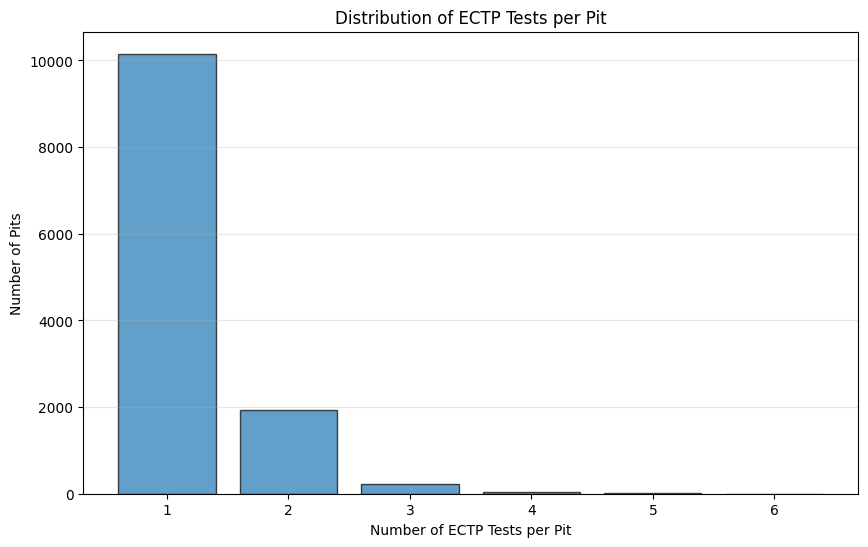

In [15]:
# Analyze pits with multiple ECTP tests
pits_with_multiple_tests = df[df['n_tests_in_pit'] > 1]['pit_id'].unique()

print(f"Pits with multiple ECTP tests: {len(pits_with_multiple_tests):,}")
print(f"Percentage of pits: {100 * len(pits_with_multiple_tests) / df['pit_id'].nunique():.1f}%")

# Distribution of number of tests per pit
tests_per_pit = df.groupby('pit_id')['n_tests_in_pit'].first().value_counts().sort_index()
print("\nDistribution of ECTP tests per pit:")
for n_tests, count in tests_per_pit.items():
    print(f"  {int(n_tests)} tests: {count:,} pits")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(tests_per_pit.index, tests_per_pit.values, edgecolor='black', alpha=0.7)
plt.xlabel('Number of ECTP Tests per Pit')
plt.ylabel('Number of Pits')
plt.title('Distribution of ECTP Tests per Pit')
plt.xticks(tests_per_pit.index)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Summary

This notebook successfully:
1. ✅ Parsed all CAAML files from the data directory
2. ✅ Created Pit objects from snowpylot SnowPit data
3. ✅ Extracted slabs using ECTP failure layers as weak layers
4. ✅ Provided comprehensive summary statistics
5. ✅ Generated visualizations of slab characteristics
6. ✅ Saved results for further analysis

### Key Findings
- Total slabs created from ECTP failures
- Distribution of slab thicknesses, number of layers, and slope angles
- Common weak layer grain forms and hardness values
- Relationship between weak layer depth and slab thickness
- Frequency of multiple ECTP tests per pit